In [55]:
from sklearn.metrics import (cohen_kappa_score, roc_curve, auc, ConfusionMatrixDisplay, f1_score,
                            accuracy_score, precision_score, recall_score,confusion_matrix, precision_recall_curve)
import joblib
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
import tensorflow as tf


from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier


In [56]:
def score(y_true, pipeline, X):
    y_pred = pipeline.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    category_metrics = pd.DataFrame({'Precision' : precision, 'Recall' : recall, 'F-1' : f1}).T.round(3)

    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f'Accuracy score: {np.round(accuracy, 3)}')
    print('==========================================================')
    print('Category metrics:')
    print(category_metrics)
    print('==========================================================')
    print(f'F1 Score (Macro): {np.round(f1, 3)}')

    

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    

In [57]:
def custom_score(y_true, model, X, attack_classes=[0, 1, 2, 4], normal_class=3):

    y_pred = model.predict(X)

    # Calculate recall for each attack class
    recall_attack = recall_score(y_true, y_pred, labels=attack_classes, average='macro', zero_division=0)
    
    # Calculate precision for the normal class
    precision_normal = precision_score(y_true, y_pred, labels=[normal_class], average='macro', zero_division=0)
    
    # Calculate overall F1-Score
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Return a dictionary with all relevant metrics
    return {
        'Recall (Attack Classes)': recall_attack,
        'Precision (Normal Class)': precision_normal,
        'F1-Score (Overall)': f1
    }

In [58]:
def plot_confusion_matrix(X, y_true, pipeline, type):
    class_names = ['DDoS', 'HTTPDoS', 'Infiltration', 'Normal', 'SSHBruteForce']
    y_pred = pipeline.predict(X)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    model_name = pipeline.named_steps['model'].__class__.__name__

    output_dir = (f"./plots/explainability/{model_name}/confusion_matrices/")
    os.makedirs(output_dir, exist_ok=True)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name} - {type}')

    plot_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{type}.png")
    plt.savefig(plot_path, bbox_inches='tight')

    plt.show()


In [60]:
# Load your test data (assuming it's saved from your training script)
test_data = pd.read_csv("data/processed/engineered_test_data.csv")
X_test = test_data.drop(columns=['Label'])
y_test = test_data['Label']

train_data = pd.read_csv("data/processed/engineered_train_data.csv")
X_train = train_data.drop(columns=['Label'])
y_train = train_data['Label']

# Binarize the output labels
class_names = ['DDoS', 'HTTPDoS', 'Infiltration', 'Normal', 'SSHBruteForce']
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

# Get the feature names from the test data
feature_names = X_test.columns.tolist()

results = []

# Traditional Machine Learning

## Logistic Regression

In [61]:
logistic_regression = joblib.load(os.path.join("data/models/", "logistic_regression_model.pkl"))
multi_output_model = logistic_regression.named_steps['model']

y_score = logistic_regression.predict_proba(X_test)

### Feature Importance

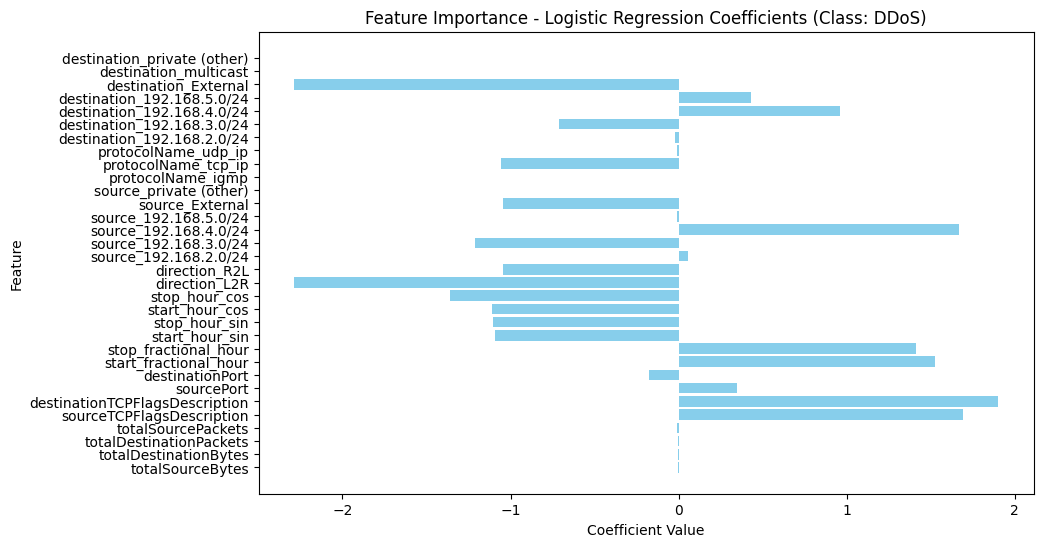

Plot saved to ./plots/explainability/LogisticRegression/feature_impotance\logistic_coefficients_DDoS.png


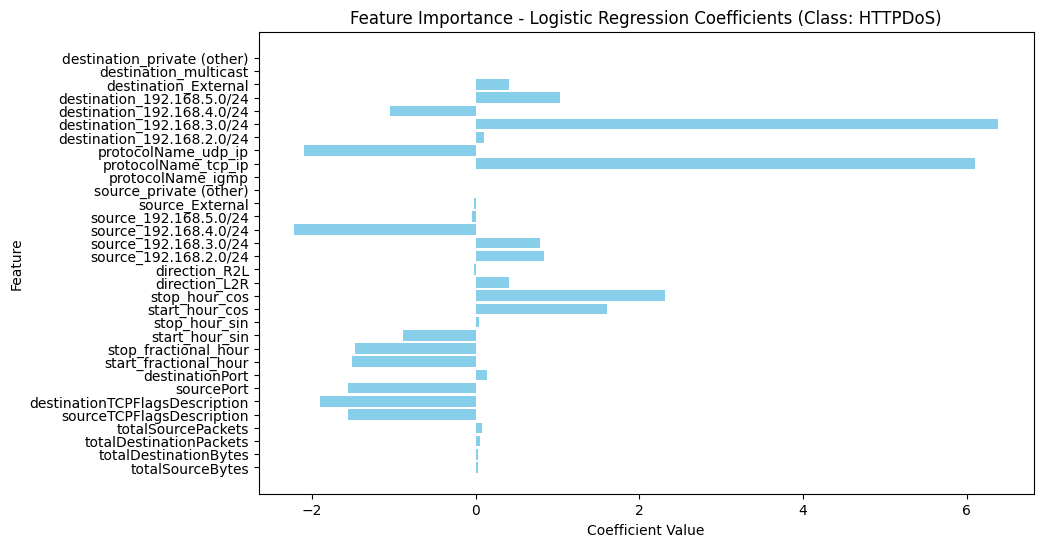

Plot saved to ./plots/explainability/LogisticRegression/feature_impotance\logistic_coefficients_HTTPDoS.png


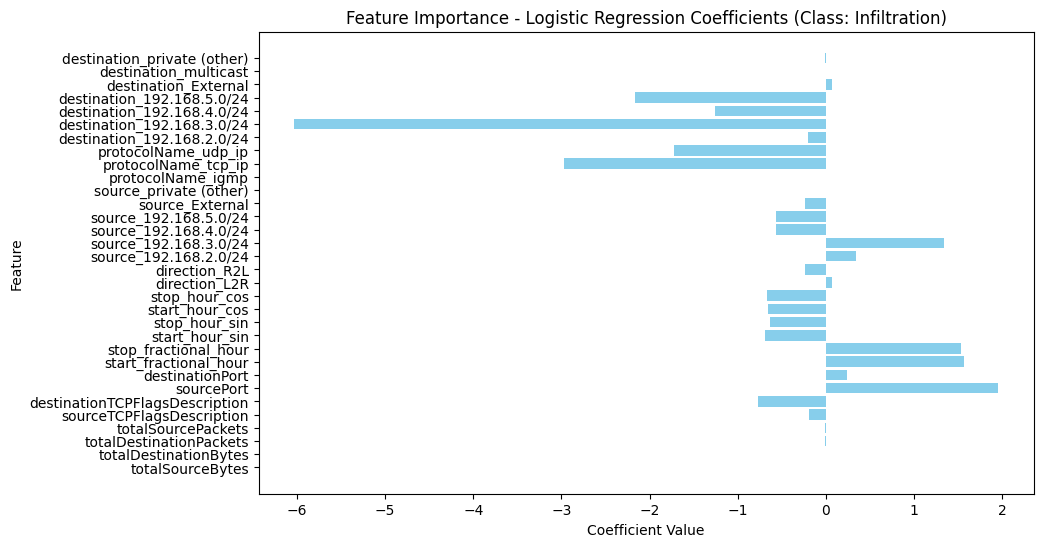

Plot saved to ./plots/explainability/LogisticRegression/feature_impotance\logistic_coefficients_Infiltration.png


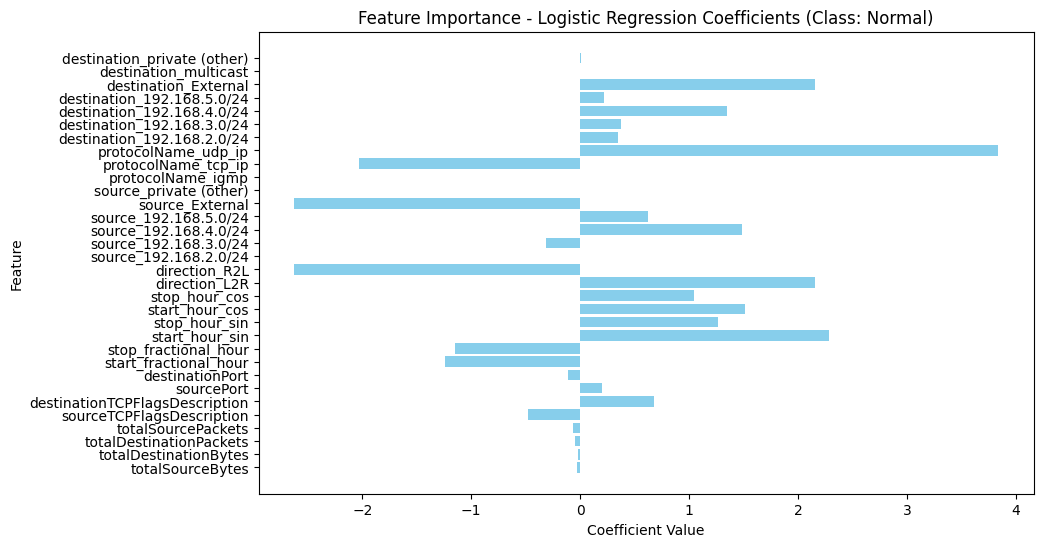

Plot saved to ./plots/explainability/LogisticRegression/feature_impotance\logistic_coefficients_Normal.png


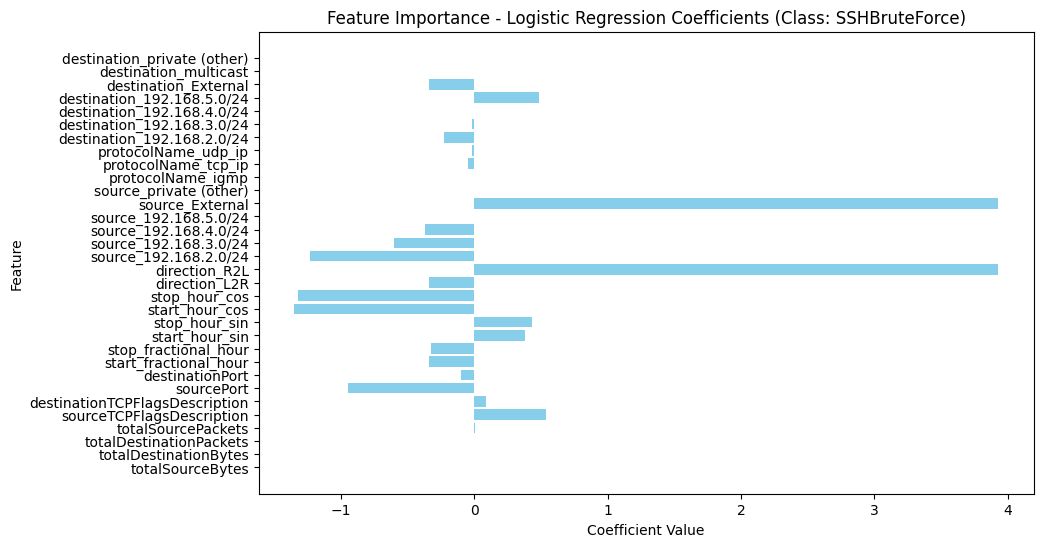

Plot saved to ./plots/explainability/LogisticRegression/feature_impotance\logistic_coefficients_SSHBruteForce.png


In [62]:
# Define the directory to save the plots
output_dir = "./plots/explainability/LogisticRegression/feature_impotance"
os.makedirs(output_dir, exist_ok=True)

# Plot coefficients for each class and save the plots
n_classes = len(multi_output_model.classes_)
for i in range(n_classes):
    coefficients = multi_output_model.coef_[i]  # Coefficients for class i
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance - Logistic Regression Coefficients (Class: {class_names[i]})")
    
    # Save the plot to the specified directory
    plot_path = os.path.join(output_dir, f"logistic_coefficients_{class_names[i]}.png")
    plt.savefig(plot_path, bbox_inches='tight')
    
    plt.show()

    print(f"Plot saved to {plot_path}")


### Confusion Matrix

#### Train

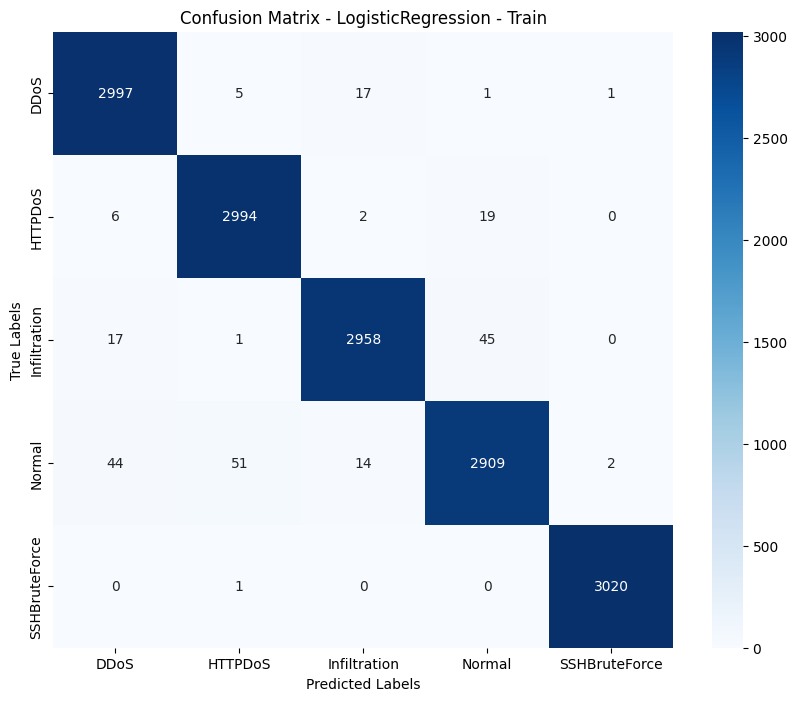

In [63]:
plot_confusion_matrix(X_train, y_train, logistic_regression, 'Train')

#### Test

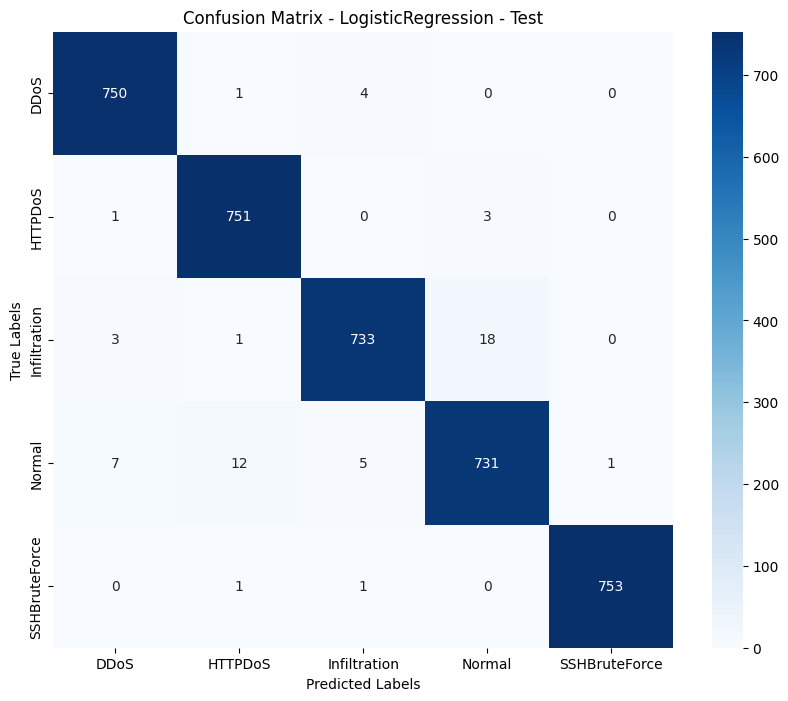

In [64]:
plot_confusion_matrix(X_test, y_test, logistic_regression, 'Test')

### Scoring

#### Test

In [65]:
result= score(y_test, logistic_regression, X_test) #Test
result['Model'] = 'Logistic Regression'
results.append(result)

Accuracy score: 0.985
Category metrics:
               0      1      2      3      4
Precision  0.986  0.980  0.987  0.972  0.999
Recall     0.993  0.995  0.971  0.967  0.997
F-1        0.989  0.988  0.979  0.969  0.998
F1 Score (Macro): 0.985


In [66]:
# Custom model evaluation
custom_metrics = custom_score(y_test, logistic_regression, X_test)
print(custom_metrics)


{'Recall (Attack Classes)': 0.9890728476821191, 'Precision (Normal Class)': 0.9720744680851063, 'F1-Score (Overall)': 0.9846200524925859}


#### Train

In [67]:
score(y_train, logistic_regression, X_train)

Accuracy score: 0.985
Category metrics:
               0      1      2      3      4
Precision  0.978  0.981  0.989  0.978  0.999
Recall     0.992  0.991  0.979  0.963  1.000
F-1        0.985  0.986  0.984  0.971  0.999
F1 Score (Macro): 0.985


{'Accuracy': 0.9850370762711864,
 'Precision': 0.9850495300759606,
 'Recall': 0.985035633567237,
 'F1-Score': 0.9850112484838665}

## Random Forest

In [68]:
random_forest = joblib.load(os.path.join("data/models/", "random_forest_model.pkl"))
random_forest_model = random_forest.named_steps['model']
y_score = random_forest.predict_proba(X_test)

### Tree Graphs

In [69]:
# Directory to save tree diagrams
output_dir = "./plots/explainability/RandomForestClassifier/tree_diagrams"
os.makedirs(output_dir, exist_ok=True)

# Loop through the first few trees in the forest (or more if desired)
for i in range(min(3, len(random_forest_model.estimators_))):  # Change the range as needed
    # Extract individual decision tree
    tree = random_forest_model.estimators_[i]
    
    # Export as dot file
    dot_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=feature_names,
        class_names=class_names,
        filled=True, 
        rounded=True, 
        special_characters=True, 
        proportion=True,  # Show probabilities at each node
        impurity=False  # Disable Gini/entropy impurity
    )
    
    # Convert to a graph
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    # Save the graph as a PDF or PNG
    graph.write_pdf(os.path.join(output_dir, f"tree_{i}.pdf"))
    graph.write_png(os.path.join(output_dir, f"tree_{i}.png"))
    
    print(f"Tree {i} diagram saved as 'tree_{i}.pdf' and 'tree_{i}.png' in {output_dir}")


Tree 0 diagram saved as 'tree_0.pdf' and 'tree_0.png' in ./plots/explainability/RandomForestClassifier/tree_diagrams
Tree 1 diagram saved as 'tree_1.pdf' and 'tree_1.png' in ./plots/explainability/RandomForestClassifier/tree_diagrams
Tree 2 diagram saved as 'tree_2.pdf' and 'tree_2.png' in ./plots/explainability/RandomForestClassifier/tree_diagrams


### Feature Importance

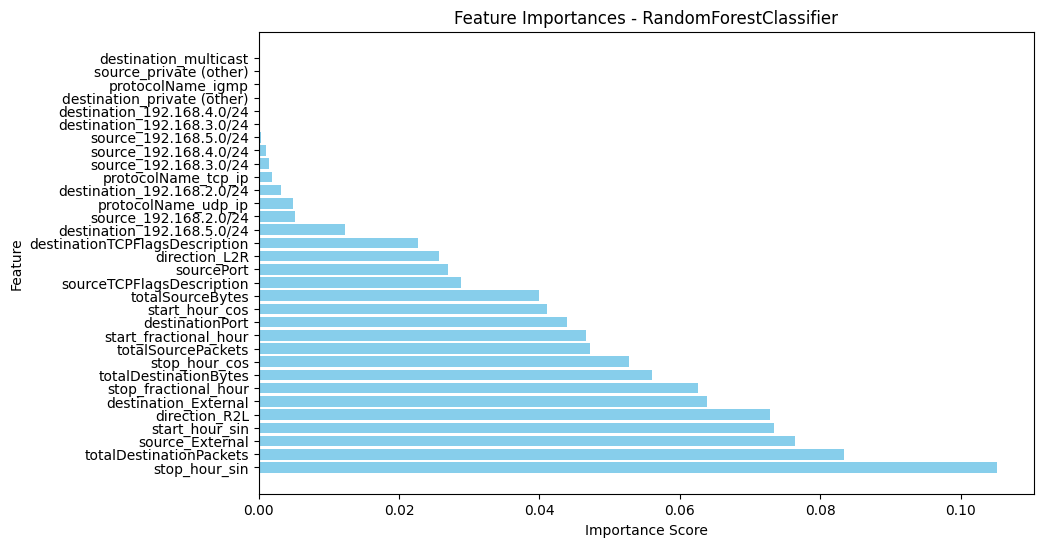

In [70]:
# Feature Importances
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

output_dir = "./plots/explainability/RandomForestClassifier/feature_importances"
os.makedirs(output_dir, exist_ok=True)


# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - RandomForestClassifier")
plt.barh(range(len(indices)), importances[indices], align="center", color='skyblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plot_path = os.path.join(output_dir, f"feature_importance - RandomForestClassifier.png")
plt.savefig(plot_path, bbox_inches='tight')

plt.show()


### Confusion Matrices

#### Test

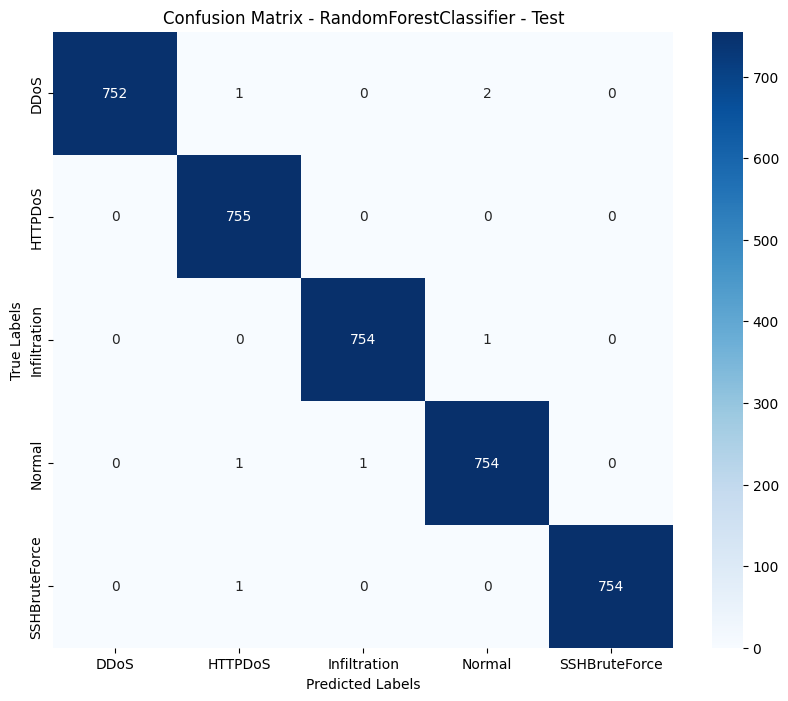

In [71]:
plot_confusion_matrix(X_test, y_test, random_forest, 'Test')

#### Train

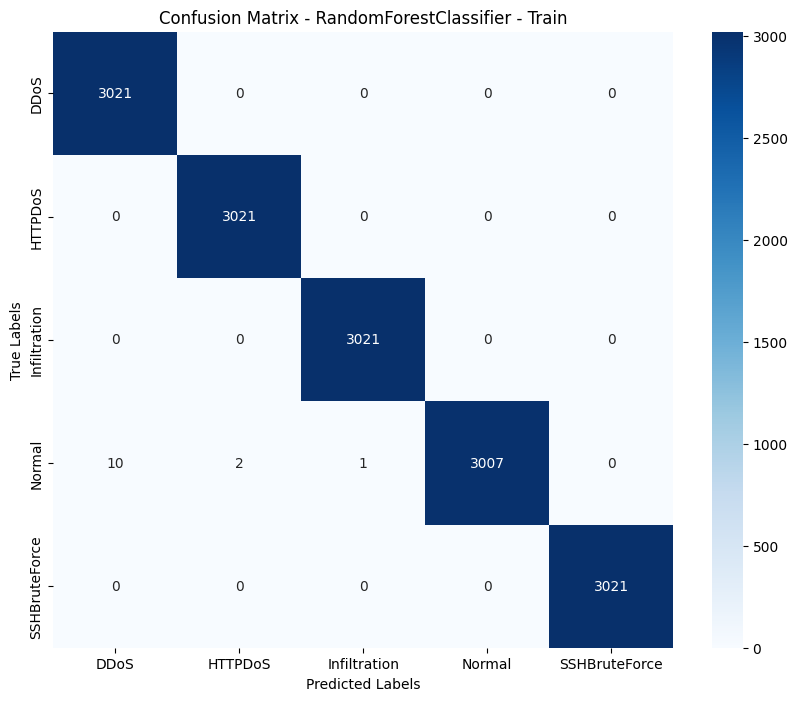

In [72]:
plot_confusion_matrix(X_train, y_train, random_forest, 'Train')

### Scoring

#### Train

In [73]:
score(y_train, random_forest, X_train)

Accuracy score: 0.999
Category metrics:
               0      1    2      3    4
Precision  0.997  0.999  1.0  1.000  1.0
Recall     1.000  1.000  1.0  0.996  1.0
F-1        0.998  1.000  1.0  0.998  1.0
F1 Score (Macro): 0.999


{'Accuracy': 0.9991393008474576,
 'Precision': 0.9991416515397097,
 'Recall': 0.9991390728476821,
 'F1-Score': 0.9991388611834567}

#### Test

In [74]:
result=score(y_test, random_forest, X_test)
result['Model']= 'RandomForest'
results.append(result)

Accuracy score: 0.998
Category metrics:
               0      1      2      3      4
Precision  1.000  0.996  0.999  0.996  1.000
Recall     0.996  1.000  0.999  0.997  0.999
F-1        0.998  0.998  0.999  0.997  0.999
F1 Score (Macro): 0.998


In [75]:
custom_score(y_test, random_forest, X_test)

{'Recall (Attack Classes)': 0.9983443708609271,
 'Precision (Normal Class)': 0.9960369881109643,
 'F1-Score (Overall)': 0.9981469175767155}

## XGBoost

In [76]:
# Load your trained pipeline
xgboost = joblib.load(os.path.join("data/models/", "xgboost_model.pkl"))
xgboost_model = xgboost.named_steps['model']

### Feature Importance

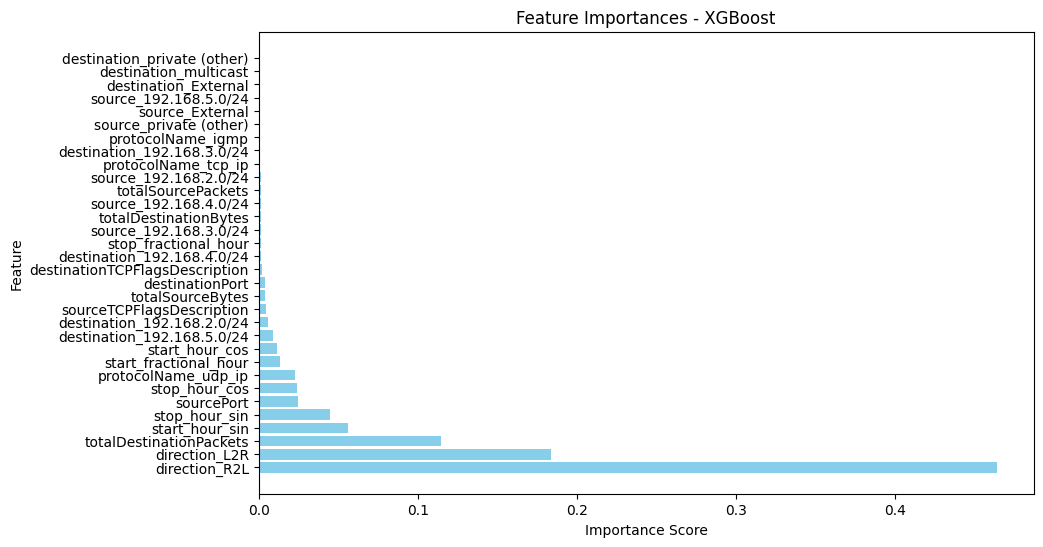

In [77]:
# Feature Importances from XGBoost
importances = xgboost_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

output_dir = (f"./plots/explainability/XGBClassifier/feature_importances")
os.makedirs(output_dir, exist_ok=True)

# Plot the feature importances of the XGBoost model
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - XGBoost")
plt.barh(range(len(indices)), importances[indices], align="center", color='skyblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plot_path = os.path.join(output_dir, f"feature_importance - XGBoost.png")
plt.savefig(plot_path, bbox_inches='tight')
    
plt.show()


### Confusion Matrices

#### Test

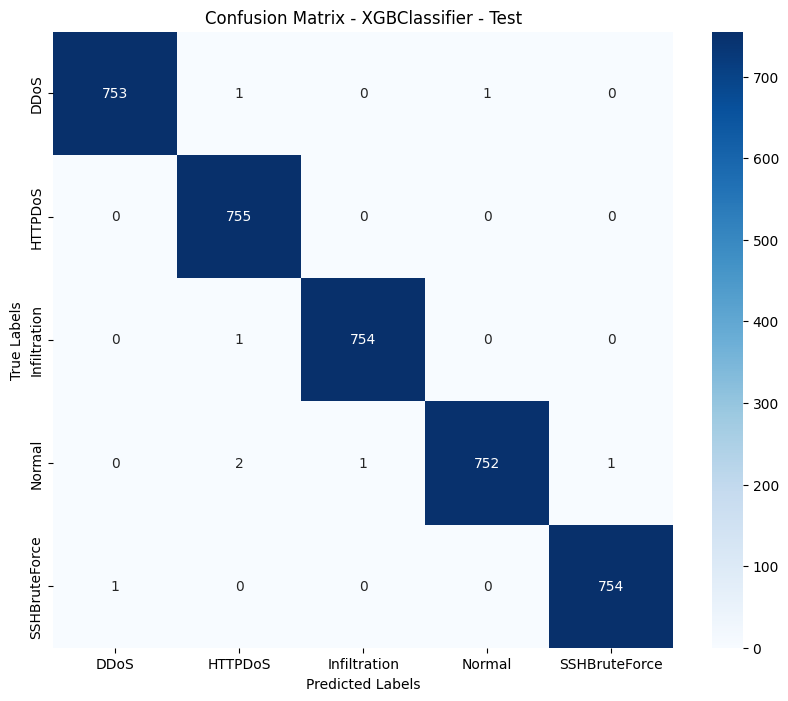

In [78]:
plot_confusion_matrix(X_test, y_test, xgboost, 'Test')

#### Train

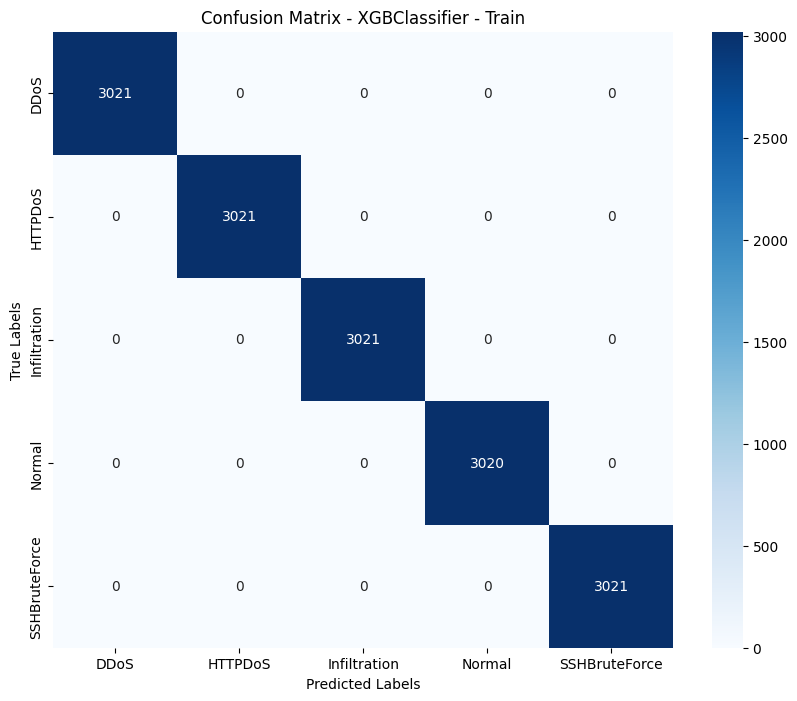

In [79]:
plot_confusion_matrix(X_train, y_train, xgboost, 'Train')

### Scoring

#### Test

In [80]:
result = score(y_test, xgboost, X_test)
result['Model'] = 'XGBClassfier'
results.append(result)

Accuracy score: 0.998
Category metrics:
               0      1      2      3      4
Precision  0.999  0.995  0.999  0.999  0.999
Recall     0.997  1.000  0.999  0.995  0.999
F-1        0.998  0.997  0.999  0.997  0.999
F1 Score (Macro): 0.998


In [81]:
custom_score(y_test, xgboost, X_test)

{'Recall (Attack Classes)': 0.9986754966887417,
 'Precision (Normal Class)': 0.99867197875166,
 'F1-Score (Overall)': 0.997881492252651}

#### Train

In [82]:
score(y_train, xgboost, X_train)

Accuracy score: 1.0
Category metrics:
             0    1    2    3    4
Precision  1.0  1.0  1.0  1.0  1.0
Recall     1.0  1.0  1.0  1.0  1.0
F-1        1.0  1.0  1.0  1.0  1.0
F1 Score (Macro): 1.0


{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0}

<hr>

## SVM

In [83]:
# Load the trained Naive Bayes model pipeline
svm = joblib.load(os.path.join("data/models/", "svm_model.pkl"))
svm_model = svm.named_steps['model']

### Feature Importance - Permutation

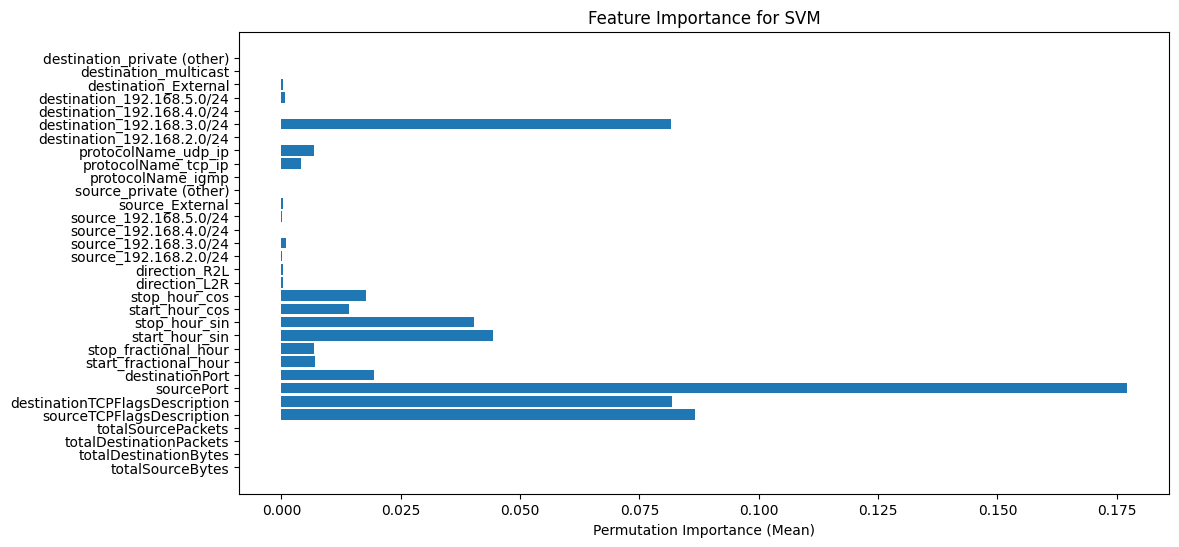

In [84]:
# Calculate permutation importances
svm_importances = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)
output_dir = "./plots/explainability/SVC/feature_importances"
os.makedirs(output_dir, exist_ok=True)


# Plot feature importances for SVM
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(svm_importances.importances_mean)), svm_importances.importances_mean, align='center')
plt.yticks(np.arange(len(X_test.columns)), X_test.columns)
plt.xlabel('Permutation Importance (Mean)')
plt.title('Feature Importance for SVM')

plot_path = os.path.join(output_dir, f"feature_importance - svm.png")
plt.savefig(plot_path, bbox_inches='tight')

plt.show()

### Confusion Matrices

#### Test

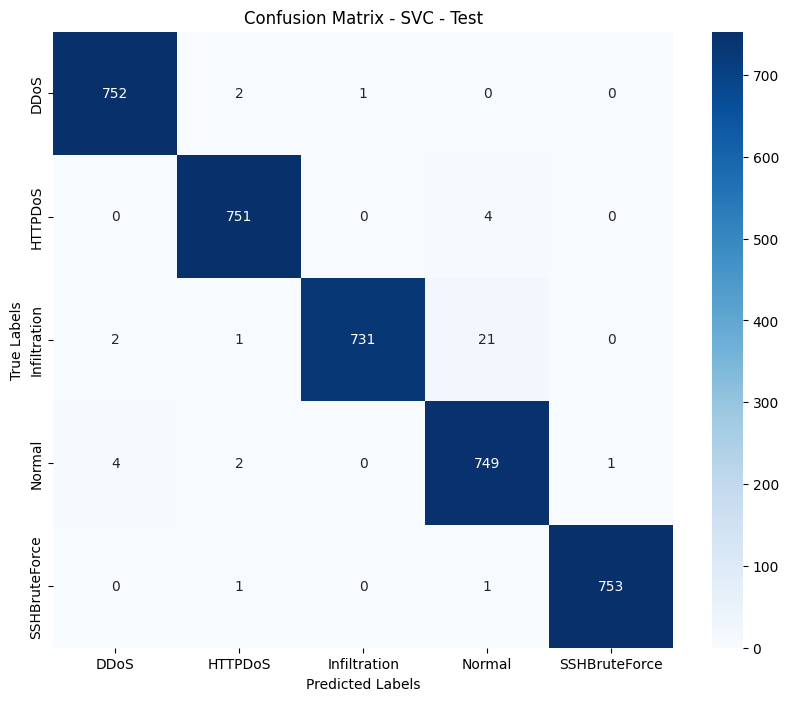

In [85]:
plot_confusion_matrix(X_test, y_test, svm, 'Test')

#### Train

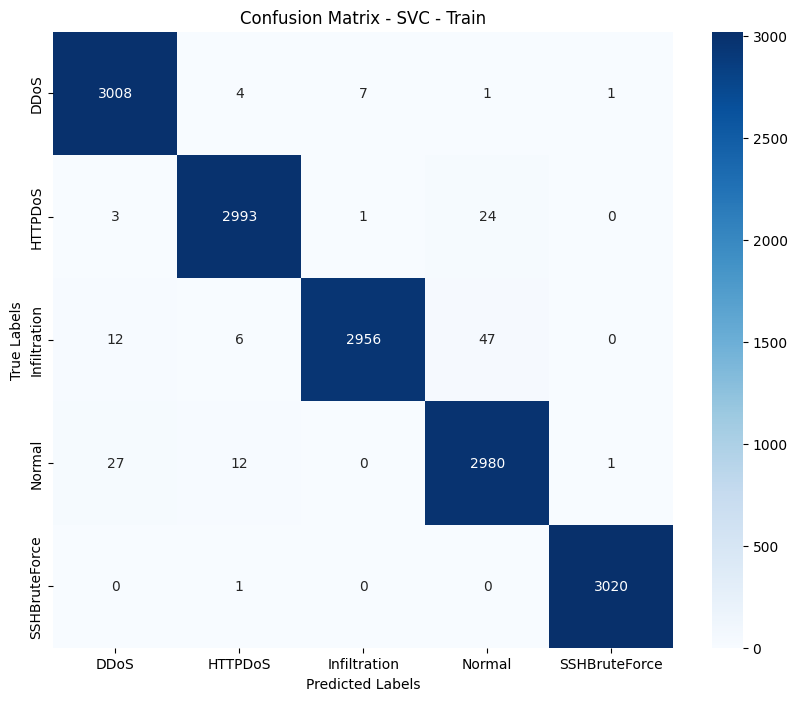

In [86]:
plot_confusion_matrix(X_train, y_train, svm, 'Train')

### Scoring

#### Test

In [87]:
result = score(y_test, svm, X_test)
result['Model'] = 'SVC'
results.append(result)


Accuracy score: 0.989
Category metrics:
               0      1      2      3      4
Precision  0.992  0.992  0.999  0.966  0.999
Recall     0.996  0.995  0.968  0.991  0.997
F-1        0.994  0.993  0.983  0.978  0.998
F1 Score (Macro): 0.989


In [88]:
custom_score(y_test, svm, X_test)

{'Recall (Attack Classes)': 0.9890728476821192,
 'Precision (Normal Class)': 0.9664516129032258,
 'F1-Score (Overall)': 0.9894165623194734}

#### Train

In [89]:
score(y_train, svm, X_train)

Accuracy score: 0.99
Category metrics:
               0      1      2      3      4
Precision  0.986  0.992  0.997  0.976  0.999
Recall     0.996  0.991  0.978  0.987  1.000
F-1        0.991  0.992  0.988  0.982  1.000
F1 Score (Macro): 0.99


{'Accuracy': 0.9902674788135594,
 'Precision': 0.9903303113982451,
 'Recall': 0.9902672462738753,
 'F1-Score': 0.9902707415734984}

## MLP

In [90]:
# Load the trained MLP model pipeline
mlp= joblib.load(os.path.join("data/models/", "mlp_model.pkl"))

# Extract the MLP model from the pipeline
mlp_model = mlp.named_steps['model']

### Feature Importance - Permutation

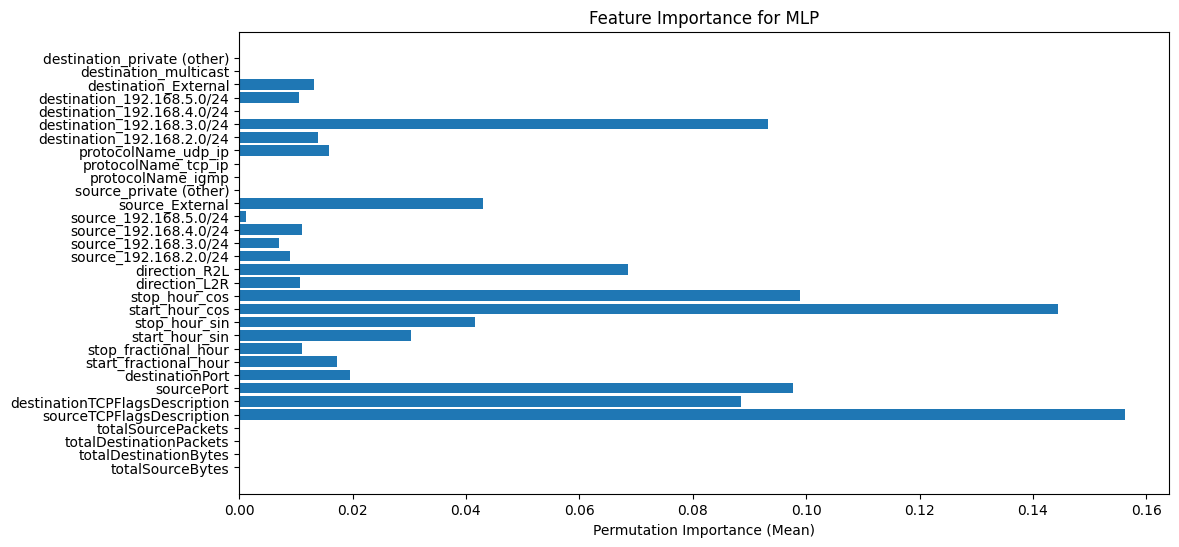

In [91]:
# Calculate permutation importances
mlp_importances = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42)

output_dir = "./plots/explainability/MLPClassifier/feature_importances"
os.makedirs(output_dir, exist_ok=True)


# Plot feature importances for MLP
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(mlp_importances.importances_mean)), mlp_importances.importances_mean, align='center')
plt.yticks(np.arange(len(X_test.columns)), X_test.columns)
plt.xlabel('Permutation Importance (Mean)')
plt.title('Feature Importance for MLP')

plot_path = os.path.join(output_dir, f"feature_importance - mlp.png")
plt.savefig(plot_path, bbox_inches='tight')
plt.show()

### Confusion Matrices

#### Test

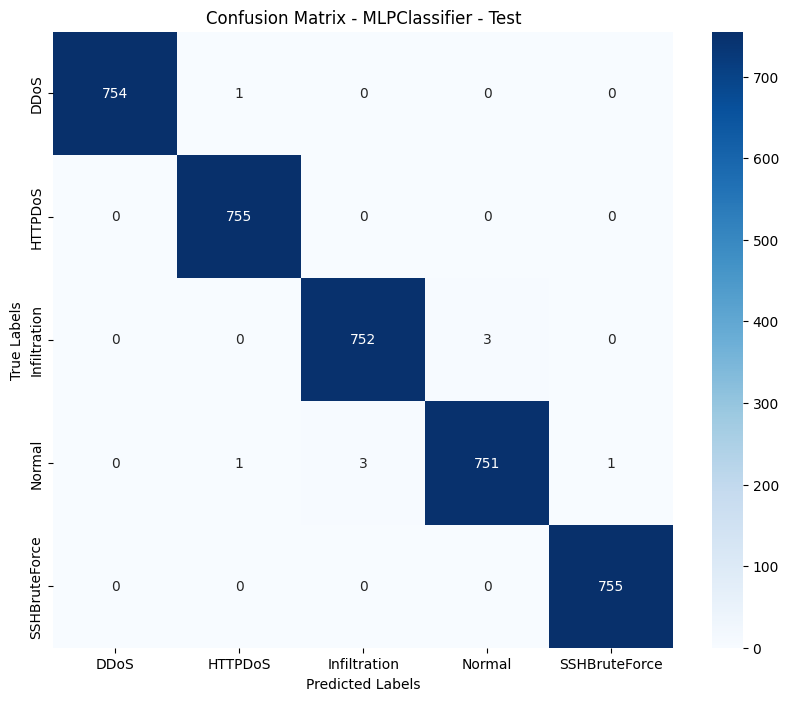

In [92]:
plot_confusion_matrix(X_test, y_test, mlp, 'Test')

#### Train

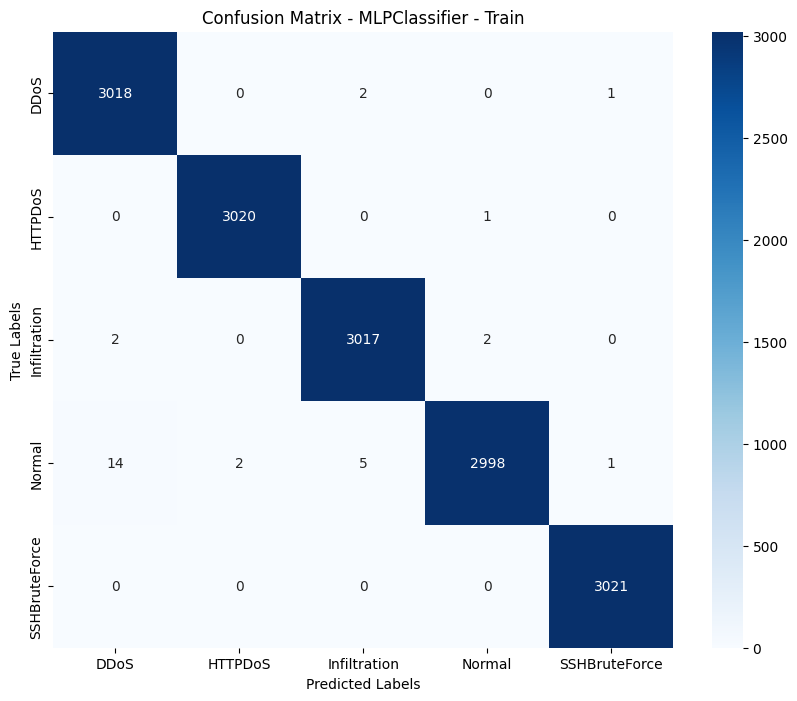

In [93]:
plot_confusion_matrix(X_train, y_train, mlp, 'Train')

### Scoring

#### Test

In [94]:
result= score(y_test, mlp, X_test)
result['Model'] = 'MLPClassfier'
results.append(result)

Accuracy score: 0.998
Category metrics:
               0      1      2      3      4
Precision  1.000  0.997  0.996  0.996  0.999
Recall     0.999  1.000  0.996  0.993  1.000
F-1        0.999  0.999  0.996  0.995  0.999
F1 Score (Macro): 0.998


In [95]:
custom_score(y_test, mlp, X_test)

{'Recall (Attack Classes)': 0.9986754966887417,
 'Precision (Normal Class)': 0.9960212201591512,
 'F1-Score (Overall)': 0.997616244321257}

#### Train

In [96]:
score(y_train, mlp, X_train)

Accuracy score: 0.998
Category metrics:
               0      1      2      3      4
Precision  0.995  0.999  0.998  0.999  0.999
Recall     0.999  1.000  0.999  0.993  1.000
F-1        0.997  1.000  0.998  0.996  1.000
F1 Score (Macro): 0.998


{'Accuracy': 0.9980137711864406,
 'Precision': 0.9980177088694063,
 'Recall': 0.9980134204059443,
 'F1-Score': 0.9980125857407398}

<hr>

# Convolutional Neural Networks

### Saliency Maps

In [97]:
# Ensure all data is numeric by converting boolean columns to float
X_test_float = X_test.astype(float)  # Convert all columns to float

# Reshape X_test for CNN input (assuming the models expect 1D input)
X_test_cnn = X_test_float.values.reshape(X_test_float.shape[0], X_test_float.shape[1], 1)


In [98]:
# Load the models
simple_cnn = tf.keras.models.load_model('data/models/simple_cnn_model.h5')
intermediate_cnn = tf.keras.models.load_model('data/models/intermediate_cnn_model.h5')
advanced_cnn = tf.keras.models.load_model('data/models/advanced_cnn_model.h5')


In [99]:
# Define the saliency map generation function
def generate_saliency_map(model, X, class_idx):
    """
    Generate a saliency map for a given input and class index.
    
    :param model: Trained CNN model
    :param X: Input data (single example) as a tf.Tensor
    :param class_idx: Class index for which to compute the saliency map
    :return: Saliency map as a numpy array
    """
    X = tf.convert_to_tensor(X, dtype=tf.float32)  # Ensure the input is a tf.Tensor
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
        loss = predictions[:, class_idx]

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, X)

    # Take the maximum across the channels
    saliency_map = np.max(np.abs(gradient), axis=-1)

    return saliency_map.flatten()  # Return as a flattened NumPy array

In [100]:
# Define the saliency map plotting function with feature names
def plot_saliency_map(saliency_map, feature_names, model_name, title="Saliency Map"):
    """
    Plot the saliency map.
    
    :param saliency_map: Saliency map as a numpy array
    :param feature_names: List of feature names to be used as x-axis labels
    :param model_name: Name of the model to include in the title
    :param title: Title of the plot
    """

    output_dir = "./plots/explainability/cnn/saliency_map"
    os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(saliency_map)), saliency_map)
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.title(f"{title} - {model_name}")
    plt.xlabel("Features")
    plt.ylabel("Saliency")
    plt.tight_layout()

    plot_path = os.path.join(output_dir, f"saliency_map - {model_name}.png")
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()



In [101]:
# Select a single sample from the test set and its corresponding class
sample_index = 0  # You can change this to explore different samples
X_single = X_test_cnn[sample_index:sample_index + 1]  # Take the sample
X_single_tensor = tf.convert_to_tensor(X_single, dtype=tf.float32)  # Convert the sample to a tf.Tensor
class_idx = np.argmax(y_test_binarized[sample_index])  # Get the index of the true class

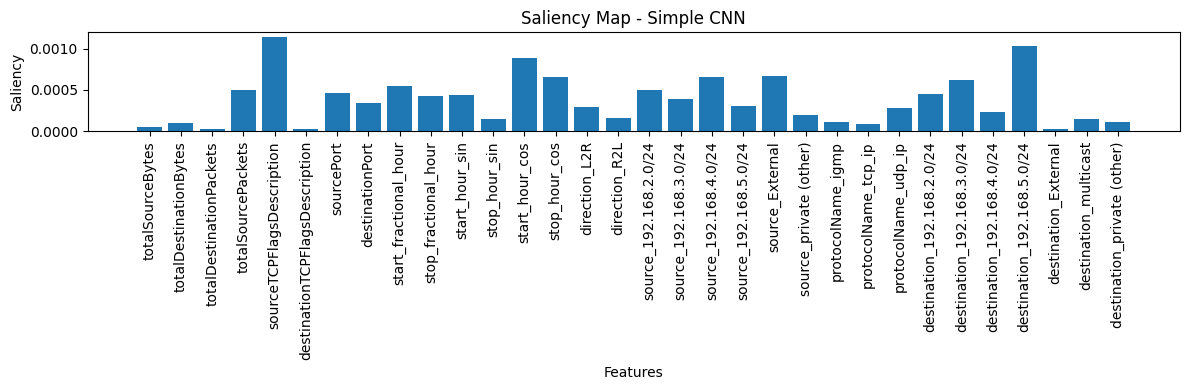

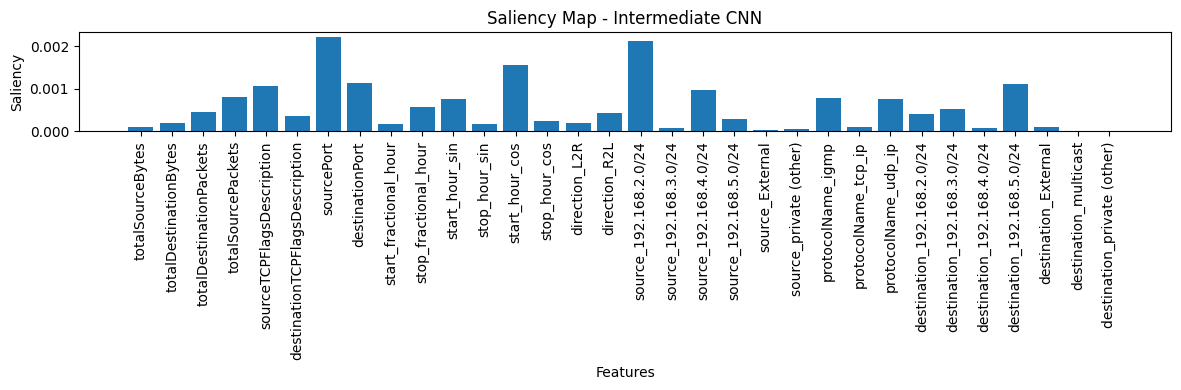

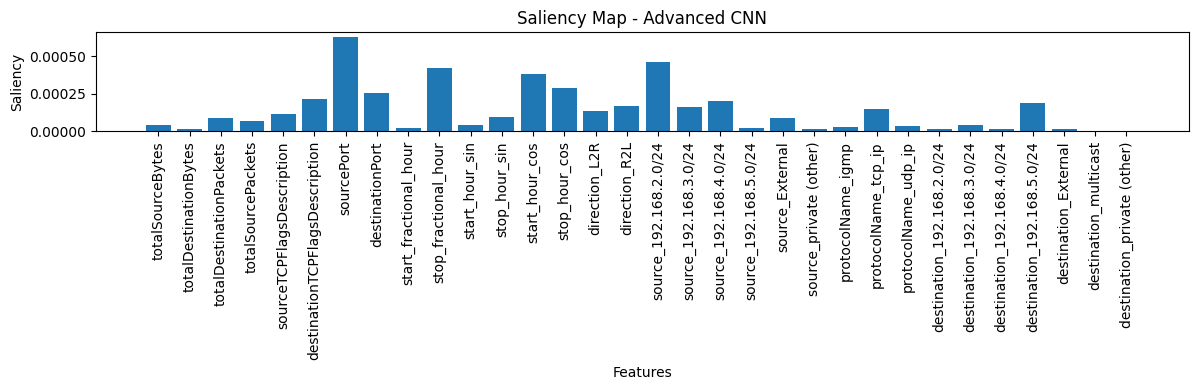

In [102]:
# Generate and plot saliency maps for each model
for model, name in zip([simple_cnn, intermediate_cnn, advanced_cnn], ['Simple CNN', 'Intermediate CNN', 'Advanced CNN']):
    saliency_map = generate_saliency_map(model, X_single_tensor, class_idx)
    plot_saliency_map(saliency_map, feature_names, name)


### Confusion Matrices

In [103]:
def plot_confusion_matrix_cnn(y_test, X_test, model, model_name,type):
    # Create the confusion matrix display

    output_dir = (f"./plots/explainability/cnn/confusion_matrices/")
    os.makedirs(output_dir, exist_ok=True)

    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name} - {type}')

    plot_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{type}.png")
    plt.savefig(plot_path, bbox_inches='tight')

    plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


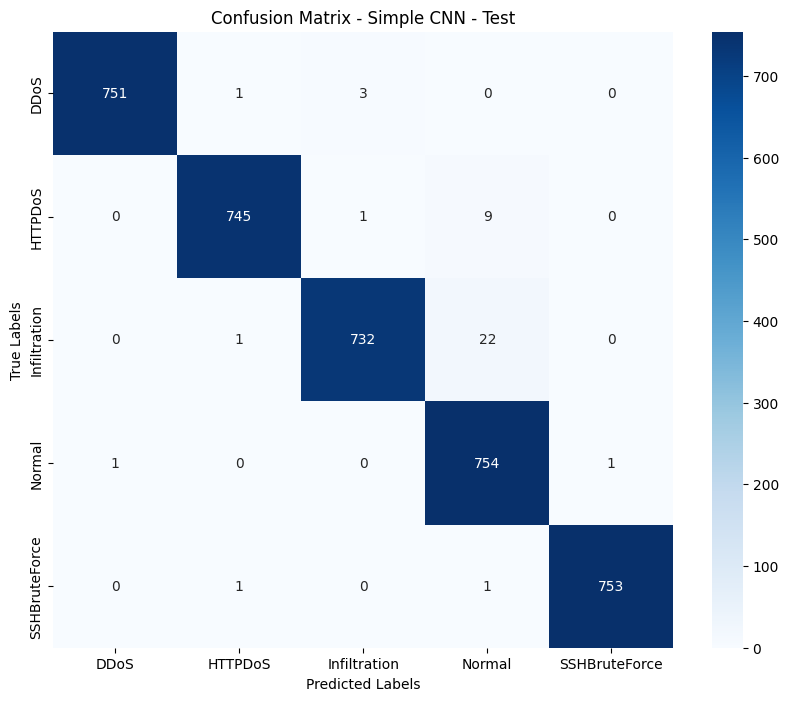

472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


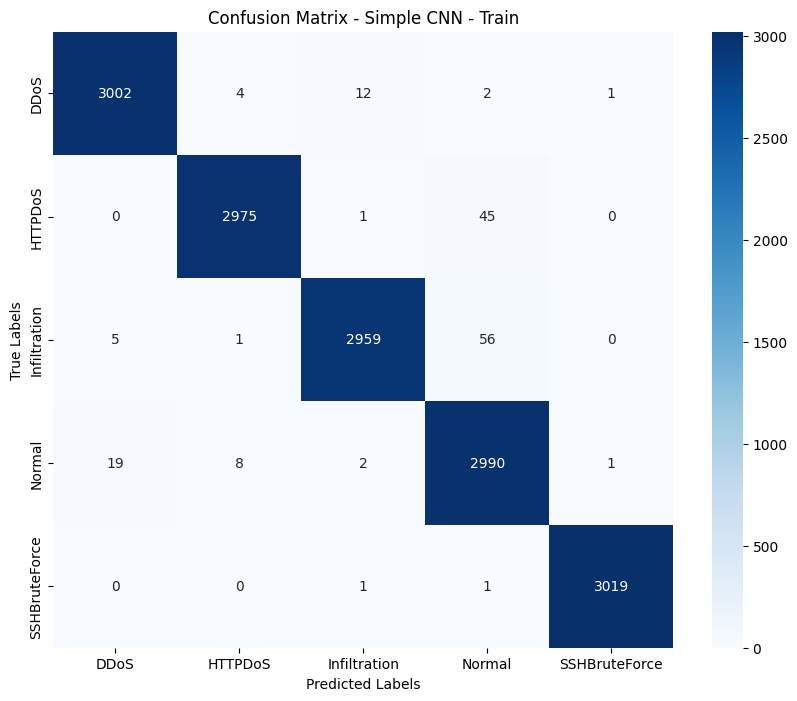

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


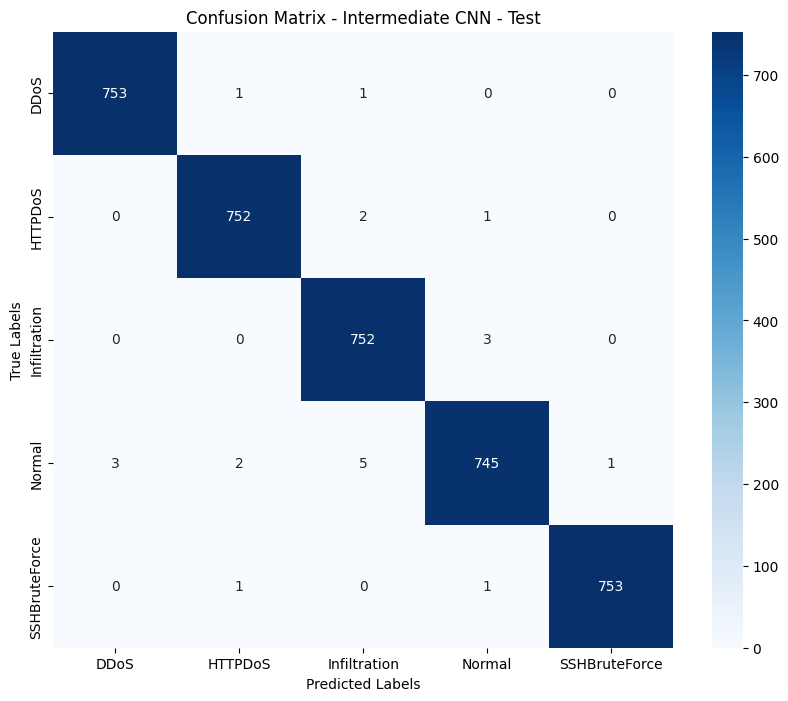

472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


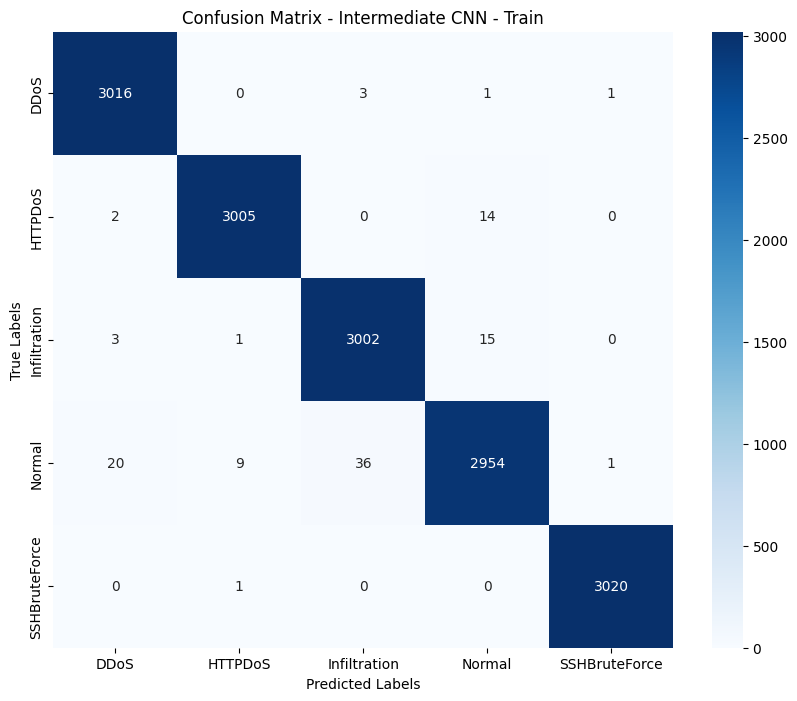

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


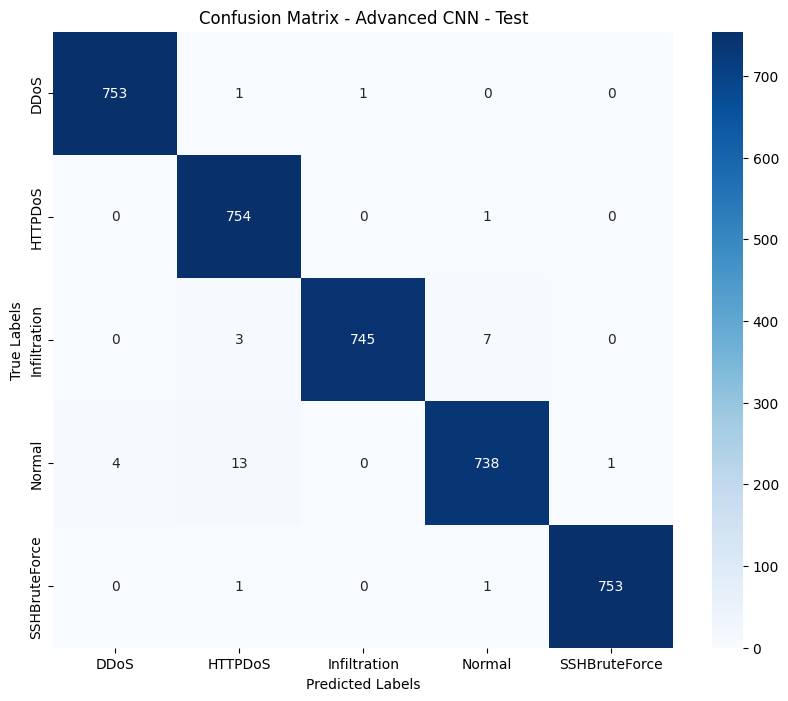

472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


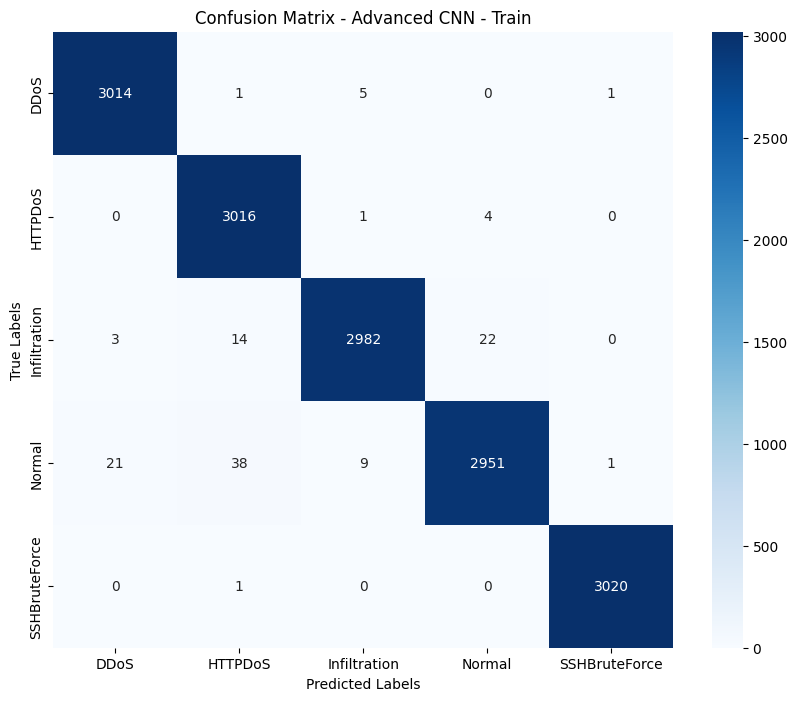

In [104]:
for model, name in zip([simple_cnn, intermediate_cnn, advanced_cnn], ['Simple CNN', 'Intermediate CNN', 'Advanced CNN']):
    plot_confusion_matrix_cnn(y_test, X_test, model, name, 'Test')
    plot_confusion_matrix_cnn(y_train, X_train, model, name, 'Train')

### Scoring

In [105]:
def score_cnn(y_true, model, X):
    # Predict probabilities and convert to class labels
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Create a DataFrame to display category metrics
    category_metrics = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F-1': f1}).T.round(3)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Print results
    print(f'Accuracy score: {np.round(accuracy, 3)}')
    print('==========================================================')
    print('Category metrics:')
    print(category_metrics)
    print('==========================================================')
    print(f'F1 score (Macro): {np.round(f1, 3)}')

    

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
    }


In [106]:
for model, name in zip([simple_cnn, intermediate_cnn, advanced_cnn], ['Simple CNN', 'Intermediate CNN', 'Advanced CNN']):
    print(f'\t {name}')
    print(f'Test')
    result = score_cnn(y_test, model, X_test)
    result['Model'] = name
    results.append(result)

    print('\n')
    print(f'Train')
    score_cnn(y_train, model, X_train)
    print('\n')
    print('\n')

	 Simple CNN
Test
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy score: 0.989
Category metrics:
               0      1      2      3      4
Precision  0.999  0.996  0.995  0.959  0.999
Recall     0.995  0.987  0.970  0.997  0.997
F-1        0.997  0.991  0.982  0.978  0.998
F1 score (Macro): 0.989


Train
472/472 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
Accuracy score: 0.989
Category metrics:
               0      1      2      3      4
Precision  0.992  0.996  0.995  0.966  0.999
Recall     0.994  0.985  0.979  0.990  0.999
F-1        0.993  0.990  0.987  0.978  0.999
F1 score (Macro): 0.989




	 Intermediate CNN
Test
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step
Accuracy score: 0.994
Category metrics:
               0      1      2      3      4
Precision  0.996  0.995  0.989  0.993  0.999
Recall     0.997  0.996  0.996  0.985  0.997
F-1        0.997  0.995  0.993  0.989  0.998
F1 score (Macro): 0.994


Train
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy score: 0.993
Category metri

# Final evaluation

In [107]:
results_df = pd.DataFrame(results)


In [108]:
results_df

,Accuracy,Precision,Recall,F1-Score,Model
0,0.984640,0.984650,0.984645,0.984620,Logistic Regression
1,0.998146,0.998151,0.998146,0.998147,RandomForest
2,0.997881,0.997885,0.997882,0.997881,XGBClassfier
3,0.989407,0.989584,0.989406,0.989417,SVC
4,0.997617,0.997617,0.997618,0.997616,MLPClassfier
5,0.989142,0.989437,0.989140,0.989177,Simple CNN
6,0.994439,0.994444,0.994441,0.994437,Intermediate CNN
7,0.991261,0.991337,0.991265,0.991262,Advanced CNN


In [109]:
# Compare models based on Cohen Kappa Score or other metrics
def find_best_model(df, metric='F1-Score'):
    best_model = df.loc[df[metric].idxmax()]
    print(f"The best model based on {metric} is {best_model['Model']} with a score of {best_model[metric]:.3f}")
    return best_model

best_model = find_best_model(results_df)

The best model based on F1-Score is RandomForest with a score of 0.998
